<a href="https://colab.research.google.com/github/SovetovAleksey/Data_analysis_algorithms/blob/6_quest/6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np

In [2]:
from sklearn.datasets import load_diabetes

In [3]:
X, y = load_diabetes(return_X_y=True)

Разделим выборку на обучающую и тестовую в соотношении 75/25.

In [4]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

Напишем функцию, реализующую предсказание в градиентном бустинге.

In [5]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже считаются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функцию.

In [6]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

Используем $L_{2}$ loss $L(y, z) = (y-z)^{2},$ её производная по $z$ примет вид $L'(y, z) = 2(z-y)$. Реализуем её также в виде функции — коэффициент 2 можно отбросить.

In [7]:
def bias(y, z):
    return (y - z)

Реализуем функцию обучения градиентного бустинга.

In [8]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

Теперь обучим несколько моделей с разными параметрами и исследуем их поведение.

In [9]:
# Число деревьев в ансамбле
n_trees = 10

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [10]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    train_prediction = gb_predict(X_train, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

In [11]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 1 на тренировочной выборке: 1085.7565241343068
Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 1 на тестовой выборке: 5526.781282644126


Построим графики зависимости ошибки на обучающей и тестовой выборках от числа итераций.

In [12]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [13]:
def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

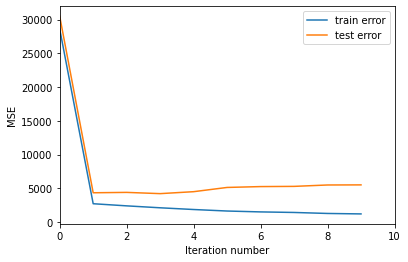

In [14]:
get_error_plot(n_trees, train_errors, test_errors)

Такой результат не считается удовлетворительным.

Увеличим число деревьев.

In [15]:
%%time
n_trees = 50
coefs = [1] * n_trees

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

CPU times: user 1min 46s, sys: 10.2 s, total: 1min 56s
Wall time: 1min 45s


In [16]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 1 на тренировочной выборке: 54.43139444164278
Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 1 на тестовой выборке: 6555.124021483446


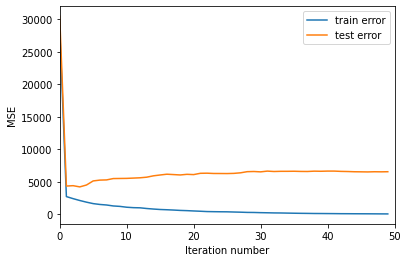

In [17]:
get_error_plot(n_trees, train_errors, test_errors)

Теперь попробуем уменьшить шаг.

In [18]:
eta = 0.1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [19]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.1 на тренировочной выборке: 1368.4090606043305
Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.1 на тестовой выборке: 3670.2335211011814


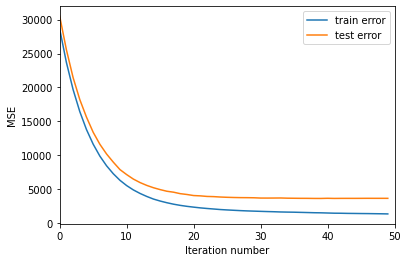

In [20]:
get_error_plot(n_trees, train_errors, test_errors)

Видим, что качество обучения улучшается.

Уменьшим шаг до 0.01.

In [21]:
eta = 0.01

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [22]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.01 на тренировочной выборке: 12104.487482742215
Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.01 на тестовой выборке: 13959.064079913647


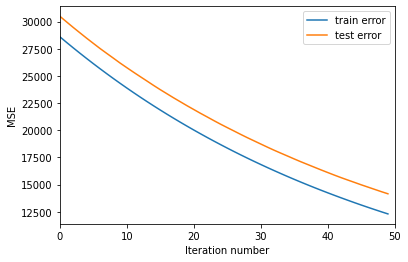

In [23]:
get_error_plot(n_trees, train_errors, test_errors)

При таком размере шага алгоритм сходится, но ему для достижения удовлетворительных показателей требуется больше итераций.

Вернёмся к шагу 0.1 и попробуем увеличить глубину деревьев.

In [24]:
eta = 0.1
max_depth = 5

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [25]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 50 деревьев глубиной 5     с шагом 0.1 на тренировочной выборке: 311.1205515180628
Ошибка алгоритма из 50 деревьев глубиной 5     с шагом 0.1 на тестовой выборке: 4084.809207473516


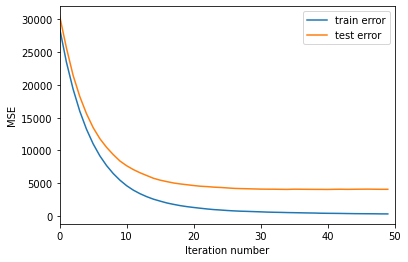

In [26]:
get_error_plot(n_trees, train_errors, test_errors)

В целом, здесь мы показали, что, варьируя параметры обучения градиентного бустинга, можно добиваться различного уровня точности модели.